## EA run comparisons 2010

Read all experiment data:

In [5]:
import os
import pandas as pd
import glob
import re
import numpy as np

run_directory_prefix = "../models/NarxModelSearch/runs/"
file_name_pattern = "*Runs.csv"
columns = ["datetime", "iteration", "island", "cvMseMean", "cvMseStd", "cvSmapeMean", "cvSmapeStd", "holdoutRmse", "holdoutSmape", "holdoutMape", "holdoutMse", "holdoutIoa", "full_parameters"]

#experiment_directories = ["18CellularAutomata3DGrid3x3x3_5AgentsO3_2000-2010_1_station_lerp"]
# experiment_directories = ["18CellularAutomata3DGrid3x3x3_5AgentsO3_2000-2010_1_station_lerp"]

# BO
#experiment_directories = ["500iters3years128units_BO2", "500iters3years128units_BO3", "500iters3years128units_BO4", "500iters3years128units_BO5", "500iters3years128units_BO1"]

# RS
# experiment_directories = [
#     "500iters3years128units_RS3",
#     "500iters3years128units_RS2", # TODO: Probs
#     "500iters3years128units_RS1",
#     "500iters3years128units_RS4"
# ]

# Island
experiment_directories = ["500iters3years128units_Island5_2", "500iters3years128units_Island5_1", "500iters3years128units_Island5_3",  "500iters3years128units_Island5_5", "500iters3years128units_Island5_4"]

run_directories = []
for experiment_directory in experiment_directories:
    new_run_directory = run_directory_prefix + experiment_directory + "/"
#     print("new_run_directory:", new_run_directory)
    run_directories.append(new_run_directory)

worker_directories = ["local", "TX2", "EC2"]

# print(run_directories)

dirs_list = []
for run_directory in run_directories:
    dirs_list.append(os.listdir(run_directory))
#     print("dirs:", os.listdir(run_directory))
    
for dirs in dirs_list:
    for item in dirs:
        if item not in worker_directories:
            sub_items = os.listdir(run_directories[0] + item)
            for sub_item in sub_items:
                sub_path = item +"/" + sub_item
#                 print("sub_path:", item +"/" + sub_item)
                worker_directories.append(sub_path)
            
# print("worker_directories:", worker_directories)

paths = []
for run_directory in run_directories:
    for worker_directory in worker_directories:
        experiment = ""
        if run_directory.startswith(run_directory_prefix):
            experiment = run_directory[len(run_directory_prefix):-1]
#         print("experiment:", experiment)
        paths.append((run_directory + worker_directory + "/logs/", worker_directory, experiment))

# print(len(paths))
    
frames = []
for path in paths:
    for csv_file_path in glob.glob(path[0] + file_name_pattern):
#         print("csv_file_path:", csv_file_path)
#         print("csv_file     :", csv_file)
        df = pd.read_csv(csv_file_path, names=columns, engine="python", index_col="datetime", parse_dates=True)
    
        if "EC2" in path[1]:  # EC2 -> + 1 hour (Ireland)
            df.index = df.index + 3600
        if "TX2" in path[1]:  # TX2 -> + 2 hours (UTC)        
            df.index = df.index + 3600 * 2
    
        df.sort_index(inplace=True)
        df["optimizer"] = str(re.search('(.{1,6})Runs.csv', os.path.basename(csv_file_path)).group(1))
        df["worker"] = path[1]
        df["experiment"] = path[2]
        df["cvSmapeMeanAccuracy"] = 100 - df["cvSmapeMean"]
        df["holdoutSmapeAccuracy"] = 100 - df["holdoutSmape"]        
#         print("df.shape", df.shape)
        frames.append(df)
#         break

df = pd.concat(frames)
df.sort_index(inplace=True)

print("df.shape:", df.shape)
df.tail()        

df.shape: (2459, 17)


,iteration,island,cvMseMean,cvMseStd,cvSmapeMean,cvSmapeStd,holdoutRmse,holdoutSmape,holdoutMape,holdoutMse,holdoutIoa,full_parameters,optimizer,worker,experiment,cvSmapeMeanAccuracy,holdoutSmapeAccuracy
datetime,,,,,,,,,,,,,,,,,
1596676862,77,1,745.805557,235.530089,33.195806,5.612198,24.734526,31.278210,64.484051,611.796772,0.534243,"[31.0, 600.0, 4.0, 128.0, 128.0, 128.0, 0.0218...",ga,TX2,500iters3years128units_Island5_5,66.804194,68.721790
1596676990,78,3,869.512135,322.800605,35.172976,6.909147,27.167976,34.393708,68.630236,738.098920,0.100203,"[26.041248555192876, 488.54747026823065, 2.894...",de,TX2,500iters3years128units_Island5_5,64.827024,65.606292
1596677071,79,1,722.599650,253.706628,32.706966,5.927105,24.259181,31.526741,62.109897,588.507878,0.547502,"[31.0, 600.0, 4.0, 128.0, 128.0, 128.0, 0.0218...",ga,TX2,500iters3years128units_Island5_5,67.293034,68.473259
1596677408,80,2,356.290644,40.912190,25.404376,2.410678,17.373973,23.891802,37.506981,301.854941,0.852188,"[19.223122800208593, 571.4499815737653, 2.2777...",bo,TX2,500iters3years128units_Island5_5,74.595624,76.108198
1596679084,81,5,716.223995,238.182776,32.376498,5.754334,24.347029,31.295868,61.750576,592.777816,0.371690,"[26.129967822699765, 511.2898930208708, 2.8029...",pso,TX2,500iters3years128units_Island5_5,67.623502,68.704132


Best MAPE% and IOA%:

In [4]:
df.sort_values(by=['holdoutMse'], ascending=True).head(5)

,iteration,island,cvMseMean,cvMseStd,cvSmapeMean,cvSmapeStd,holdoutRmse,holdoutSmape,holdoutMape,holdoutMse,holdoutIoa,full_parameters,optimizer,worker,experiment,cvSmapeMeanAccuracy,holdoutSmapeAccuracy
datetime,,,,,,,,,,,,,,,,,
1595910067,196,5,347.606516,34.478162,25.206186,2.821356,16.856377,23.972319,37.546130,284.137442,0.861696,"[7.0, 455.0, 0.0, 99.0, 110.0, 96.0, 0.0621143...",rand,local,500iters3years128units_RS1,74.793814,76.027681
1595952243,158,1,417.075955,98.404388,27.910892,3.389196,16.946000,24.094681,36.666170,287.166919,0.869297,"[28.0, 552.0, 1.0, 71.0, 124.0, 101.0, 0.17113...",rand,local,500iters3years128units_RS2,72.089108,75.905319
1595969044,272,1,391.706883,16.567755,26.338960,2.794390,16.992740,24.040165,38.465260,288.753224,0.858649,"[9.0, 494.0, 4.0, 74.0, 126.0, 113.0, 0.143688...",rand,local,500iters3years128units_RS2,73.661040,75.959835
1596721272,43,4,391.142775,41.858653,26.411413,2.478063,17.004525,23.975129,38.312800,289.153883,0.854937,"[29.0, 372.0, 2.0, 101.0, 67.0, 77.0, 0.012363...",rand,local,500iters3years128units_RS4,73.588587,76.024871
1595907437,172,2,343.364249,48.711975,25.028530,2.986076,17.014669,23.885503,37.903724,289.498958,0.857346,"[13.0, 487.0, 0.0, 76.0, 81.0, 100.0, 0.053526...",rand,local,500iters3years128units_RS1,74.971470,76.114497


In [6]:
df.sort_values(by=['cvMseMean'], ascending=True).head(5)

,iteration,island,cvMseMean,cvMseStd,cvSmapeMean,cvSmapeStd,holdoutRmse,holdoutSmape,holdoutMape,holdoutMse,holdoutIoa,full_parameters,optimizer,worker,experiment,cvSmapeMeanAccuracy,holdoutSmapeAccuracy
datetime,,,,,,,,,,,,,,,,,
1596324576,40,1,320.042121,44.295821,24.781869,2.872147,17.226090,24.560606,34.118157,296.738171,0.872871,"[27.993951965631258, 571.536337708036, 0.30903...",bo,local,500iters3years128units_BO4,75.218131,75.439394
1596300386,102,1,322.907067,35.287393,24.609021,2.877120,17.189371,24.613234,34.231558,295.474474,0.873103,"[27.993951965631258, 571.536337708036, 0.30903...",bo,local,500iters3years128units_BO4,75.390979,75.386766
1596265759,6,1,324.583847,41.327697,24.668781,2.960396,17.187573,24.536239,35.107988,295.412679,0.869973,"[27.993951965631258, 571.536337708036, 0.30903...",bo,local,500iters3years128units_BO3,75.331219,75.463761
1596314096,127,1,325.165857,33.606865,24.720625,3.091506,17.188760,24.687326,34.692409,295.453473,0.870017,"[27.993951965631258, 571.536337708036, 0.30903...",bo,local,500iters3years128units_BO4,75.279375,75.312674
1596335512,105,1,326.612810,37.002182,24.593091,3.029533,17.192863,24.580634,34.875434,295.594525,0.868954,"[27.993951965631258, 571.536337708036, 0.30903...",bo,local,500iters3years128units_BO4,75.406909,75.419366


In [7]:
df.sort_values(by=['holdoutIoa'], ascending=False).head(5)

,iteration,island,cvMseMean,cvMseStd,cvSmapeMean,cvSmapeStd,holdoutRmse,holdoutSmape,holdoutMape,holdoutMse,holdoutIoa,full_parameters,optimizer,worker,experiment,cvSmapeMeanAccuracy,holdoutSmapeAccuracy
datetime,,,,,,,,,,,,,,,,,
1596002649,1,1,369.532534,38.091257,26.233524,3.422976,17.193041,24.580806,35.593614,295.600662,0.880573,"[17.008528112861775, 530.0811233605396, 0.0004...",bo,local,500iters3years128units_BO1,73.766476,75.419194
1596059615,287,1,390.947650,66.951133,27.758851,3.109574,17.849039,25.623753,34.561420,318.588200,0.880276,"[7.295598550000479, 531.6929809026428, 3.89313...",bo,local,500iters3years128units_BO1,72.241149,74.376247
1596380598,12,1,385.689665,61.604247,26.937859,3.213685,17.160720,24.663929,33.829148,294.490307,0.880120,"[17.008528112861775, 530.0811233605396, 0.0004...",bo,local,500iters3years128units_BO5,73.062141,75.336071
1596380232,7,1,378.836342,55.486868,26.730775,3.154164,17.369072,24.721212,34.905383,301.684664,0.879134,"[17.008528112861775, 530.0811233605396, 0.0004...",bo,local,500iters3years128units_BO5,73.269225,75.278788
1596065392,317,1,398.374745,70.756983,27.537359,3.289847,17.639623,25.418842,35.491463,311.156287,0.878924,"[7.295598550000479, 531.6929809026428, 3.89313...",bo,local,500iters3years128units_BO1,72.462641,74.581158


In [8]:
df.sort_values(by=['holdoutSmape'], ascending=True).head(10)

,iteration,island,cvMseMean,cvMseStd,cvSmapeMean,cvSmapeStd,holdoutRmse,holdoutSmape,holdoutMape,holdoutMse,holdoutIoa,full_parameters,optimizer,worker,experiment,cvSmapeMeanAccuracy,holdoutSmapeAccuracy
datetime,,,,,,,,,,,,,,,,,
1596363998,34,1,404.994183,81.686978,27.333224,2.625860,16.881452,23.661532,35.993025,284.983426,0.867036,"[21.158101969842182, 427.4847842113137, 0.5167...",bo,local,500iters3years128units_BO4,72.666776,76.338468
1596038470,206,1,361.281570,39.877555,25.408048,2.329506,17.079309,23.696646,37.973003,291.702784,0.852583,"[25.520040019031896, 553.9165848947813, 1.2105...",bo,local,500iters3years128units_BO1,74.591952,76.303354
1596458983,137,1,343.817491,28.672097,25.054854,2.388390,17.073611,23.721341,37.612977,291.508207,0.857999,"[30.389182375439056, 487.8367538470059, 2.2276...",bo,local,500iters3years128units_BO5,74.945146,76.278659
1596167812,119,1,349.688044,51.557378,24.907046,2.411359,16.884720,23.722983,37.208562,285.093771,0.859388,"[8.158764313718223, 451.0277277545674, 1.38057...",bo,local,500iters3years128units_BO2,75.092954,76.277017
1596161025,71,1,377.453199,52.365019,26.020883,2.430592,17.318726,23.732241,38.470497,299.938267,0.849359,"[27.50190579309148, 452.7646440242543, 1.88672...",bo,local,500iters3years128units_BO2,73.979117,76.267759
1596415695,33,1,362.368733,45.479365,25.330627,2.245228,17.025391,23.741511,38.744678,289.863946,0.852442,"[25.520040019031896, 553.9165848947813, 1.2105...",bo,local,500iters3years128units_BO5,74.669373,76.258489
1596460530,147,1,386.563586,44.714652,26.364337,2.120055,17.037349,23.756548,37.619403,290.271278,0.858906,"[30.389182375439056, 487.8367538470059, 2.2276...",bo,local,500iters3years128units_BO5,73.635663,76.243452
1596174593,184,1,342.692436,48.120987,24.762692,2.849154,16.979813,23.763217,38.540705,288.314056,0.853659,"[8.158764313718223, 451.0277277545674, 1.38057...",bo,local,500iters3years128units_BO2,75.237308,76.236783
1596147986,14,1,349.000184,38.572312,24.984266,2.400361,17.011829,23.780539,38.498210,289.402330,0.853364,"[8.158764313718223, 451.0277277545674, 1.38057...",bo,local,500iters3years128units_BO2,75.015734,76.219461


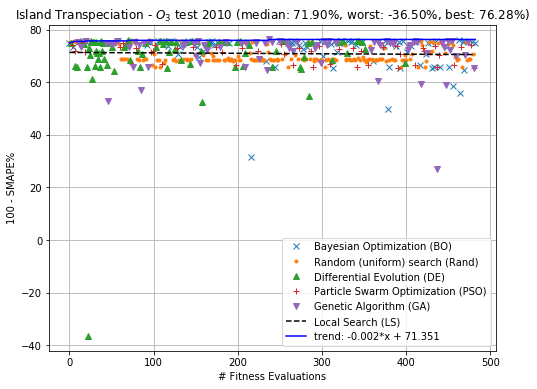

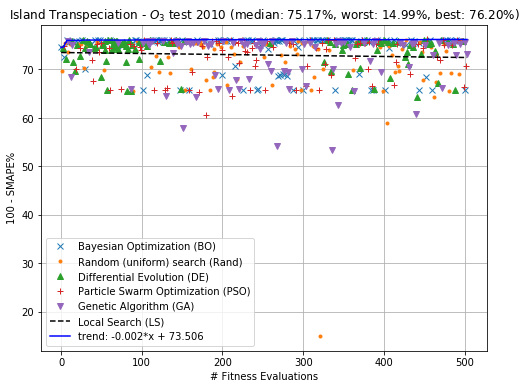

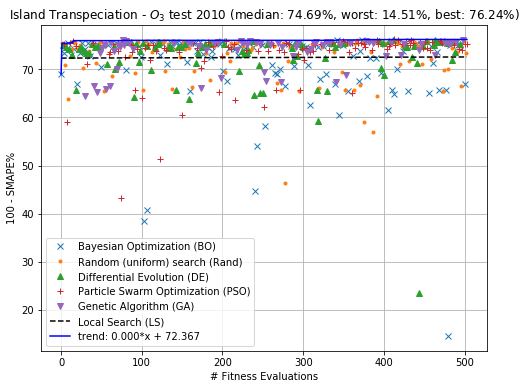

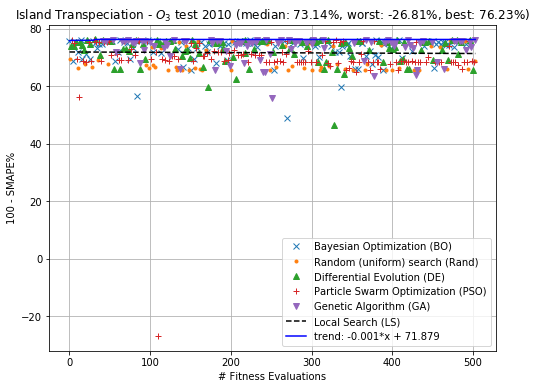

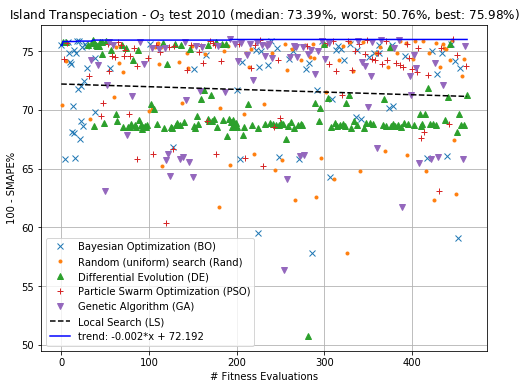

In [6]:
import numpy as np
import matplotlib.pyplot as plt

variables = [
#     "cvSmapeMeanAccuracy", 
#     "holdoutMse",
    "holdoutSmapeAccuracy",
#     "holdoutIoa"
]
figure_size = [8, 6]
remove_outliers = False
outlier_std = 3
minimizing = False

def getMinimizingMaximizingArray(k, minimizing=True):
    minsArray = []
    minValue = k[0]
    for value in np.array(k):
        if minimizing:
            if value < minValue:
                minValue = value
        else:
            if value > minValue:
                minValue = value
        minsArray.append(minValue)    
    return np.array(minsArray)
    
def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

for current_experiment in experiment_directories:
    
    legends = []
    for variable in variables:    
       
        df2 = df.loc[df["experiment"] == current_experiment]        
#         df2 = df2.loc[df2["optimizer"] != "ls"]
        
        df2 = df2.drop_duplicates()
        df2.sort_index(inplace=True)
    
        if remove_outliers:
            df2 = df2[~(np.abs(df2[variable] - df2[variable].mean()) > (outlier_std * df2[variable].std()))]
    
        dict_points = {}        
        for optimizer in df2["optimizer"].unique():
            dict_points[optimizer + "_y"] = []
            dict_points[optimizer + "_x"] = []
        i = 0
        for index, row in df2.iterrows():
            optimizer = row["optimizer"]
            dict_points[optimizer + "_y"].append(row[variable])
            dict_points[optimizer + "_x"].append(i)            
            i += 1
    
        x = np.array(range(0, len(df2[variable])))
        y = df2[variable].values 
        
        fig, ax = plt.subplots(1, 1, figsize=figure_size)
        ax.set_ylabel("100 - SMAPE%")
        ax.set_xlabel('# Fitness Evaluations')
       
#         z2 = np.polyfit(x, y, 2) 
#         trendpoly2d = np.poly1d(z2)
#         ax.plot(x, trendpoly2d(x) , 'r--')
#         legends.append("trend 2 degree polynomial")
        
#         z12 = np.polyfit(x, y, 12) 
#         trendpoly12d = np.poly1d(z12)
#         ax.plot(x, trendpoly12d(x) , 'c--')
#         legends.append("trend 12 degree polynomial")

        # Scatter plot all data points based on method    
        i = 0
        styles = ["x", ".", "^", "+", "v", "1", "*"]
        for optimizer in df2["optimizer"].unique():
            ax.plot(dict_points[optimizer + "_x"], dict_points[optimizer + "_y"], styles[i]);
#             legends.append(optimizer)
            i += 1
        legends = legends + ["Bayesian Optimization (BO)", "Random (uniform) search (Rand)", "Differential Evolution (DE)", "Particle Swarm Optimization (PSO)", "Genetic Algorithm (GA)", "Local Search (LS)"]

        # Linear regression trend
        z = np.polyfit(x, y, 1) 
        trendpoly1d = np.poly1d(z)
#         print("trendpoly1d: ", trendpoly1d)
        ax.plot(x, trendpoly1d(x) , 'k--')
        legends.append("trend: {:.3f}*x + {:.3f}".format(z[0], z[1]))        
       
        best_method = df2["optimizer"].loc[df2[variable].idxmin()].upper()
#         ax.set_title('Island Transpeciation - PM10 test accuracy (median: {:.2f}% +/- {:.2f}%, worst: {:.2f}%, best: {:.2f}%)'
#                      .format(df2[variable].median(), df2[variable].mad(), df2[variable].min(), df2[variable].max()))
        ax.set_title('Island Transpeciation - $O_3$ test 2010 (median: {:.2f}%, worst: {:.2f}%, best: {:.2f}%)'
             .format(df2[variable].median(), df2[variable].min(), df2[variable].max()))

        ax.plot(x, getMinimizingMaximizingArray(df2[variable].values, minimizing), "b-");
#         legends.append("minimizing " + variable)
        legends.append("Best model")

        ax.legend(legends)
        
        ax.grid(True)                         
        fig.savefig("{}Test.svg".format(current_experiment))
        fig.savefig("{}Test.png".format(current_experiment))
#         break
#     break

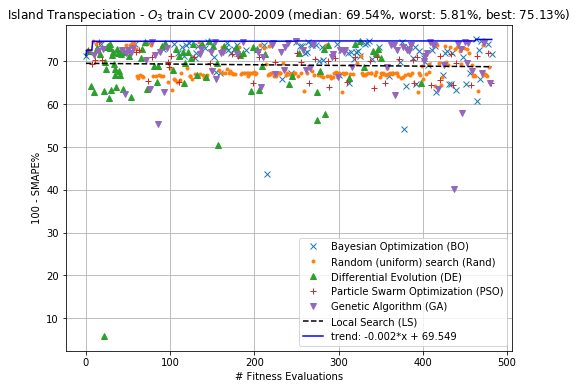

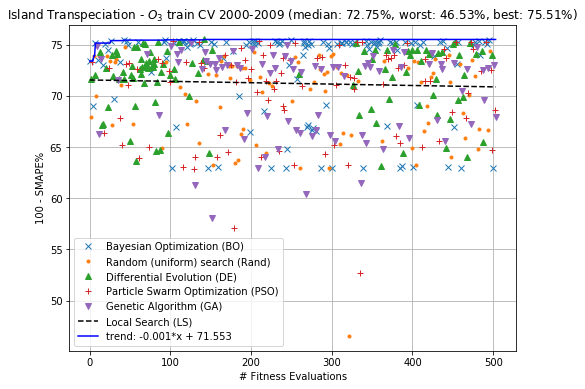

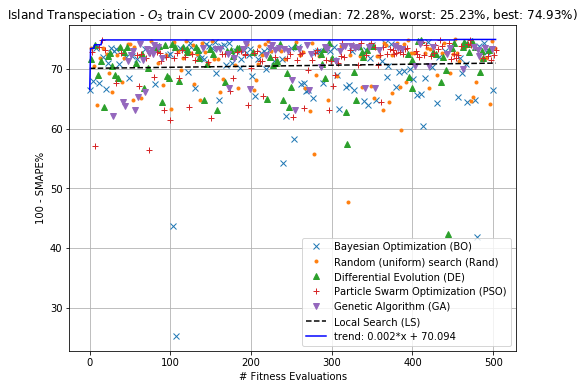

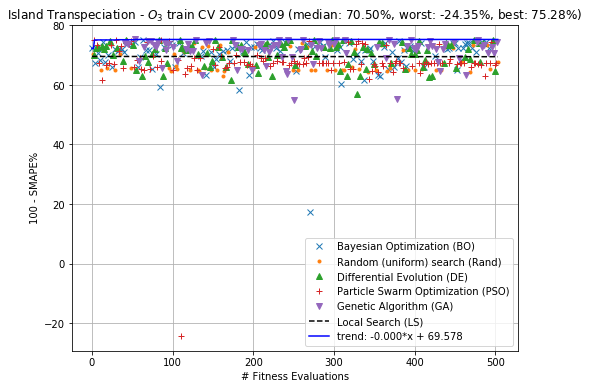

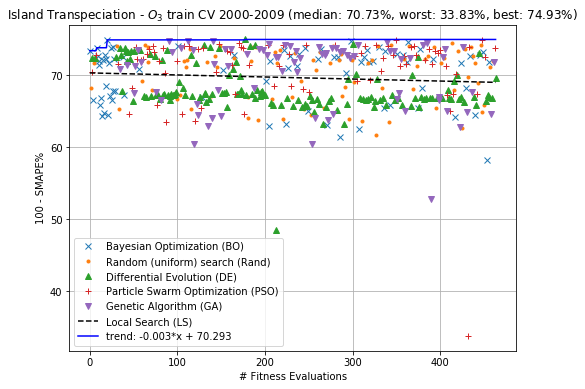

In [7]:
import numpy as np
import matplotlib.pyplot as plt

variables = [
    "cvSmapeMeanAccuracy", 
#     "holdoutMse",
#     "holdoutSmapeAccuracy",
#     "holdoutIoa"
]
figure_size = [8, 6]
remove_outliers = False
outlier_std = 3
minimizing = False

def getMinimizingMaximizingArray(k, minimizing=True):
    minsArray = []
    minValue = k[0]
    for value in np.array(k):
        if minimizing:
            if value < minValue:
                minValue = value
        else:
            if value > minValue:
                minValue = value
        minsArray.append(minValue)    
    return np.array(minsArray)
    
def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

for current_experiment in experiment_directories:
    
    legends = []
    for variable in variables:    
       
        df2 = df.loc[df["experiment"] == current_experiment]        
#         df2 = df2.loc[df2["optimizer"] != "ls"]
        
        df2 = df2.drop_duplicates()
        df2.sort_index(inplace=True)
    
        if remove_outliers:
            df2 = df2[~(np.abs(df2[variable] - df2[variable].mean()) > (outlier_std * df2[variable].std()))]
    
        dict_points = {}        
        for optimizer in df2["optimizer"].unique():
            dict_points[optimizer + "_y"] = []
            dict_points[optimizer + "_x"] = []
        i = 0
        for index, row in df2.iterrows():
            optimizer = row["optimizer"]
            dict_points[optimizer + "_y"].append(row[variable])
            dict_points[optimizer + "_x"].append(i)            
            i += 1
    
        x = np.array(range(0, len(df2[variable])))
        y = df2[variable].values 
        
        fig, ax = plt.subplots(1, 1, figsize=figure_size)
        ax.set_ylabel("100 - SMAPE%")
        ax.set_xlabel('# Fitness Evaluations')
       
#         z2 = np.polyfit(x, y, 2) 
#         trendpoly2d = np.poly1d(z2)
#         ax.plot(x, trendpoly2d(x) , 'r--')
#         legends.append("trend 2 degree polynomial")
        
#         z12 = np.polyfit(x, y, 12) 
#         trendpoly12d = np.poly1d(z12)
#         ax.plot(x, trendpoly12d(x) , 'c--')
#         legends.append("trend 12 degree polynomial")

        # Scatter plot all data points based on method    
        i = 0
        styles = ["x", ".", "^", "+", "v", "1", "*"]
        for optimizer in df2["optimizer"].unique():
            ax.plot(dict_points[optimizer + "_x"], dict_points[optimizer + "_y"], styles[i]);
#             legends.append(optimizer)
            i += 1
        legends = legends + ["Bayesian Optimization (BO)", "Random (uniform) search (Rand)", "Differential Evolution (DE)", "Particle Swarm Optimization (PSO)", "Genetic Algorithm (GA)", "Local Search (LS)"]

        # Linear regression trend
        z = np.polyfit(x, y, 1) 
        trendpoly1d = np.poly1d(z)
#         print("trendpoly1d: ", trendpoly1d)
        ax.plot(x, trendpoly1d(x) , 'k--')
        legends.append("trend: {:.3f}*x + {:.3f}".format(z[0], z[1]))        
       
        best_method = df2["optimizer"].loc[df2[variable].idxmin()].upper()
#         ax.set_title('Island Transpeciation - PM10 test accuracy (median: {:.2f}% +/- {:.2f}%, worst: {:.2f}%, best: {:.2f}%)'
#                      .format(df2[variable].median(), df2[variable].mad(), df2[variable].min(), df2[variable].max()))
        ax.set_title('Island Transpeciation - $O_3$ train CV 2000-2009 (median: {:.2f}%, worst: {:.2f}%, best: {:.2f}%)'
             .format(df2[variable].median(), df2[variable].min(), df2[variable].max()))

        ax.plot(x, getMinimizingMaximizingArray(df2[variable].values, minimizing), "b-");
#         legends.append("minimizing " + variable)
        legends.append("Best model")

        ax.legend(legends)
        
        ax.grid(True)                         
        fig.savefig("{}Train.svg".format(current_experiment))    
        fig.savefig("{}Train.png".format(current_experiment))
#         break
#     break

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

variables = [
#     "cvSmapeMeanAccuracy", 
#     "holdoutMse",
    "holdoutSmapeAccuracy",
#     "holdoutIoa"
]
figure_size = [10, 8]
remove_outliers = False
outlier_std = 2
minimizing = False

def getMinimizingMaximizingArray(k, minimizing=True):
    minsArray = []
    minValue = k[0]
    for value in np.array(k):
        if minimizing:
            if value < minValue:
                minValue = value
        else:
            if value > minValue:
                minValue = value
        minsArray.append(minValue)    
    return np.array(minsArray)
    
def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

for current_experiment in experiment_directories:
    
    legends = []
    for variable in variables:    
       
        df2 = df.loc[df["experiment"] == current_experiment]
        
#         df2 = df2.loc[df2["optimizer"] != "ls"]
        
        df2 = df2.drop_duplicates()
        df2.sort_index(inplace=True)
    
        if remove_outliers:
            df2 = df2[~(np.abs(df2[variable] - df2[variable].mean()) > (outlier_std * df2[variable].std()))]
    
        dict_points = {}        
        for optimizer in df2["optimizer"].unique():
            dict_points[optimizer + "_y"] = []
            dict_points[optimizer + "_x"] = []
        i = 0
        for index, row in df2.iterrows():
            optimizer = row["optimizer"]
            dict_points[optimizer + "_y"].append(row[variable])
            dict_points[optimizer + "_x"].append(i)            
            i += 1
    
        x = np.array(range(0, len(df2[variable])))
        y = df2[variable].values 
        
        fig, ax = plt.subplots(1, 1, figsize=figure_size)
        ax.set_ylabel(variable)
        ax.set_xlabel('# Fitness Evaluations')

        # Linear regression trend
        z = np.polyfit(x, y, 1) 
        trendpoly1d = np.poly1d(z)
#         print("trendpoly1d: ", trendpoly1d)
        ax.plot(x, trendpoly1d(x) , 'k--')
        legends.append("trend " + variable + ": {:.3f}*x + {:.3f}".format(z[0], z[1]))
        
        z2 = np.polyfit(x, y, 2) 
        trendpoly2d = np.poly1d(z2)
        ax.plot(x, trendpoly2d(x) , 'r--')
        legends.append("trend 2 degree polynomial")
        
        z12 = np.polyfit(x, y, 12) 
        trendpoly12d = np.poly1d(z12)
        ax.plot(x, trendpoly12d(x) , 'c--')
        legends.append("trend 12 degree polynomial")
                
        # Scatter plot all data points based on method    
        i = 0
        styles = ["x", ".", "^", "+", "v", "1", "*"]
        for optimizer in df2["optimizer"].unique():
            ax.plot(dict_points[optimizer + "_x"], dict_points[optimizer + "_y"], styles[i]);
            legends.append(optimizer)
            i += 1

        ax.plot(x, getMinimizingMaximizingArray(df2[variable].values, minimizing), "b-");
        legends.append("minimizing " + variable)
        
        ax.legend(legends)
        best_method = df2["optimizer"].loc[df2[variable].idxmin()]
        ax.set_title('{} (evals: {}, min: {:.2f}, max: {:.2f}, median: {:.2f} +/- {:.2f}, mean: {:.2f} +/- {:.2f}, best: {}) - Experiment: {}'
                     .format(variable, len(df2[variable]), df2[variable].min(), df2[variable].max(), df2[variable].median(), df2[variable].mad(), 
                             df2[variable].mean(), df2[variable].std(), best_method, current_experiment))
        ax.grid(True) 
    
#         break
#     break

## Worker execution times: Bar chart with error bars

In [ ]:
import math
import matplotlib.pyplot as plt
import numpy as np

def flatten(seq, container=None):
    if container is None:
        container = []
    for s in seq:
        try:
            iter(s)  # check if it's iterable
        except TypeError:
            container.append(s)
        else:
            flatten(s, container)
    return container

workers = df["worker"].unique()

means = []
samples = 0
outlier_std = 3
for current_worker in workers:
    experiment_means = []
    for current_experiment in experiment_directories:
        df_worker = df.loc[df["experiment"] == current_experiment]
        df_worker = df_worker.loc[df_worker["worker"] == current_worker]
        df_worker = df_worker.drop_duplicates()
        df_worker = df_worker.dropna()
        df_worker.sort_index(inplace=True)
        df_worker['datetimestamp'] = df_worker.index                
        df_worker = df_worker[~(np.abs(df_worker["datetimestamp"] - df_worker["datetimestamp"].mean()) > (outlier_std * df_worker["datetimestamp"].std()))]        
        diff = df_worker["datetimestamp"].diff().dropna()
        mean = diff.mean(skipna=True)
        if "P100" in current_worker or "4xV100" in current_worker:
            mean *= 4        
        if mean is not None and not math.isnan(mean):
            samples += diff.size
            experiment_means.append(mean / 60.0)
    means.append(experiment_means)

# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 14))
workers = list(workers)
#fourV100 = workers.index('EC2/4xV100a')
#oneV100 = workers.index('EC2/1xV100')
#means[fourV100].append(means[oneV100][0])
#del means[oneV100]

all_data = means
labels = []
for x, y in zip(['GTX 970 & 1070Ti', 'Jetson TX2'], [np.mean(x) for x in all_data]):
    labels.append("{}\n({:.2f} mins/model)".format(x, y))

axes[0].violinplot(all_data, showmeans=False, showmedians=True)
axes[0].set_title('Violin plot - RNN (4 layers) training times vs GPU ({} samples, 99.73% CI)'.format(samples))
axes[1].boxplot(all_data)
axes[1].set_title('Box plot - RNN (4 layers) training times vs GPU ({} samples, 99.73% CI)'.format(samples))
for ax in axes:
    ax.yaxis.grid(True)
    ax.set_xticks([y+1 for y in range(len(all_data))])
    ax.set_xlabel('GPU Workers')
    ax.set_ylabel('Time (minutes)')
plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],
         xticklabels=labels)
plt.savefig("rnnTrainingTimes.svg")
plt.savefig("rnnTrainingTimes.png")
plt.show()

In [ ]:
import math
import matplotlib.pyplot as plt
import numpy as np

def flatten(seq, container=None):
    if container is None:
        container = []
    for s in seq:
        try:
            iter(s)  # check if it's iterable
        except TypeError:
            container.append(s)
        else:
            flatten(s, container)
    return container

workers = df["worker"].unique()

means = []
samples = 0
outlier_std = 3

for current_worker in workers:
    experiment_means = []
    for current_experiment in experiment_directories:
        df_worker = df.loc[df["experiment"] == current_experiment]
        df_worker = df_worker.loc[df_worker["worker"] == current_worker]
        df_worker = df_worker.drop_duplicates()
        df_worker = df_worker.dropna()
        df_worker.sort_index(inplace=True)
        df_worker['datetimestamp'] = df_worker.index                
        df_worker = df_worker[~(np.abs(df_worker["datetimestamp"] - df_worker["datetimestamp"].mean()) > (outlier_std * df_worker["datetimestamp"].std()))]        
        diff = df_worker["datetimestamp"].diff().dropna()
        mean = diff.mean(skipna=True)
        if "P100" in current_worker or "4xV100" in current_worker:
            mean *= 4        
        if mean is not None and not math.isnan(mean):
            samples += diff.size
            experiment_means.append(mean / 60.0)
    means.append(experiment_means)

# Plot


figure_size = (6, 4)  # (16, 14)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=figure_size)
workers = list(workers)
#fourV100 = workers.index('EC2/4xV100a')
#oneV100 = workers.index('EC2/1xV100')
#means[fourV100].append(means[oneV100][0])
#del means[oneV100]

all_data = means
labels = []
for x, y in zip(['GTX 970 & 1070Ti', 'Jetson TX2'], [np.mean(x) for x in all_data]):
    labels.append("{}\n≈{:.2f}\nmins/model".format(x, y))

axes.violinplot(all_data, showmeans=False, showmedians=True)
axes.set_title('Island DNN training times vs GPU ({} samples, 99.73% CI)'.format(samples))
axes.set_title('Training times vs GPU ({} samples, 99.73% CI)'.format(samples))
# axes[1].boxplot(all_data)
# axes[1].set_title('Box plot - RNN (4 layers) training times vs GPU ({} samples, 99.73% CI)'.format(samples))

axes.yaxis.grid(True)
axes.set_xticks([y+1 for y in range(len(all_data))])
axes.set_xlabel('GPU Workers')
axes.set_ylabel('Time (minutes)')
plt.setp(axes, xticks=[y+1 for y in range(len(all_data))], xticklabels=labels)
plt.savefig("rnnTrainingTimes.svg")
plt.savefig("rnnTrainingTimes.png")
plt.show()

In [ ]:
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import numpy as np


models_per_hour = []
models_per_hour_std = []
for gpu_worker in all_data:
    models_per_hour.append(np.mean(60.0 / np.array(gpu_worker)))
    models_per_hour_std.append(np.std(60.0 / np.array(gpu_worker)))
prices = [5281, (136 + 369) / 2.0, 6865, 352]
price_per_model_hour = np.array(prices) / np.array(models_per_hour)

price_per_model_hour_std = price_per_model_hour * (np.array(models_per_hour_std) / np.array(models_per_hour))
print("price_per_model_hour_std", price_per_model_hour_std)

gpu_workers = ['GTX 970 & 1070Ti', 'Jetson TX2']
price_per_model_hour = [x for y,x in sorted(zip(gpu_workers, price_per_model_hour))]
gpu_workers = [y for y,x in sorted(zip(gpu_workers, price_per_model_hour))]

price_per_model_hour_std = [26.98099847, 64.96931466, 495.39481663,  110.15980803]  # TODO: hardcoded

x = np.arange(4)
def millions(x, pos):
    return '{:.0f} €'.format(x)

formatter = FuncFormatter(millions)

fig, ax = plt.subplots(figsize=(12, 4))
ax.xaxis.set_major_formatter(formatter)
plt.barh(x, price_per_model_hour, xerr=price_per_model_hour_std)
# plt.barh(x, price_per_model_hour)
ax.set_title('Cost per model-hour - RNN (4 layers) vs GPU ({} samples 99.73% CI)'.format(samples))
ax.set_ylabel('GPU Workers')
ax.set_xlabel('Price (€)')
plt.yticks(x, gpu_workers)
for i, v in enumerate(price_per_model_hour):
    ax.text(v + 4, i + 0.1, str(round(v, 1)) + "€ +/- {:.1f}€ per model-hour".format(price_per_model_hour_std[i]) , color='blue', fontweight='bold')
plt.show()

## All models structure

In [ ]:
import os
import pandas as pd
import glob
import re
import numpy as np
import matplotlib.pyplot as plt

run_directory_prefix = "../models/NarxModelSearch/runs/"
file_name_pattern = "*Runs.csv"
columns = ["datetime", "iteration", "island", "cvMseMean", "cvMseStd", "cvSmapeMean", "cvSmapeStd", "holdoutRmse", "holdoutSmape", "holdoutMape", "holdoutMse", "holdoutIoa", "full_parameters"]

experiment_directories = ["18CellularAutomata3DGrid3x3x3_5AgentsO3_2000-2010_1_station_lerp"]

run_directories = []
for experiment_directory in experiment_directories:
    new_run_directory = run_directory_prefix + experiment_directory + "/"
#     print("new_run_directory:", new_run_directory)
    run_directories.append(new_run_directory)

worker_directories = ["local", "TX2"]

# print(run_directories)

dirs_list = []
for run_directory in run_directories:
    dirs_list.append(os.listdir(run_directory))
#     print("dirs:", os.listdir(run_directory))
    
for dirs in dirs_list:
    for item in dirs:
        if item not in worker_directories:
            sub_items = os.listdir(run_directories[0] + item)
            for sub_item in sub_items:
                sub_path = item +"/" + sub_item
#                 print("sub_path:", item +"/" + sub_item)
                worker_directories.append(sub_path)
            
# print("worker_directories:", worker_directories)

paths = []
for run_directory in run_directories:
    for worker_directory in worker_directories:
        experiment = ""
        if run_directory.startswith(run_directory_prefix):
            experiment = run_directory[len(run_directory_prefix):-1]
#         print("experiment:", experiment)
        paths.append((run_directory + worker_directory + "/logs/", worker_directory, experiment))

# print(len(paths))
    
frames = []
for path in paths:
    for csv_file_path in glob.glob(path[0] + file_name_pattern):
#         print("csv_file_path:", csv_file_path)
#         print("csv_file     :", csv_file)
        df = pd.read_csv(csv_file_path, names=columns, engine="python", index_col="datetime", parse_dates=True)
    
        if "EC2" in path[1]:  # EC2 -> + 1 hour (Ireland)
            df.index = df.index + 3600
        if "TX2" in path[1]:  # TX2 -> + 2 hours (UTC)        
            df.index = df.index + 3600 * 2
    
        df.sort_index(inplace=True)
        df["optimizer"] = str(re.search('(.{1,6})Runs.csv', os.path.basename(csv_file_path)).group(1))
        df["worker"] = path[1]
        df["experiment"] = path[2]
        df["cvSmapeMeanAccuracy"] = 100 - df["cvSmapeMean"]
        df["holdoutSmapeAccuracy"] = 100 - df["holdoutSmape"]
        
        full_parameters = []
        for params in df["full_parameters"].tolist():
#             print(params)
            full_parameters.append([float(z) for z in params.replace('[', '').replace(']', '').split(", ")])

        df["full_parameters"] = full_parameters        
        a = ["batch_size",
            "epoch_size",
            "optimizer",
            "units1",
            "units2",
            "units3",
            "dropout1",
            "dropout2",
            "dropout3",
            "recurrent_dropout1",
            "recurrent_dropout2",
            "recurrent_dropout3",
            "gaussian_noise_std1",
            "gaussian_noise_std2",
            "gaussian_noise_std3",
            "batch_normalization1",
            "batch_normalization2",
            "batch_normalization3",
            "gaussian_noise1",
            "gaussian_noise2",
            "gaussian_noise3",
            "layer_type1",
            "layer_type2",
            "layer_type3",
            "layer_initializer1",
            "layer_initializer2",
            "layer_initializer3"]
            
        c = 0
        for asdf in zip(*full_parameters):
            df[a[c]] = asdf
            c +=1
        
        frames.append(df)
#         break

df = pd.concat(frames)
df.sort_index(inplace=True)

print("df.shape:", df.shape)
df.tail()        

In [ ]:
import os
import pandas as pd
import glob
import re
import numpy as np
import matplotlib.pyplot as plt

run_directory_prefix = "../models/NarxModelSearch/runs/"
file_name_pattern = "*Runs.csv"
columns = ["datetime", "iteration", "island", "cvMseMean", "cvMseStd", "cvSmapeMean", "cvSmapeStd", "holdoutRmse", "holdoutSmape", "holdoutMape", "holdoutMse", "holdoutIoa", "full_parameters"]

experiment_directories = ["18CellularAutomata3DGrid3x3x3_5AgentsO3_2000-2010_1_station_lerp"]

run_directories = []
for experiment_directory in experiment_directories:
    new_run_directory = run_directory_prefix + experiment_directory + "/"
#     print("new_run_directory:", new_run_directory)
    run_directories.append(new_run_directory)

worker_directories = ["local", "TX2"]

# print(run_directories)

dirs_list = []
for run_directory in run_directories:
    dirs_list.append(os.listdir(run_directory))
#     print("dirs:", os.listdir(run_directory))
    
for dirs in dirs_list:
    for item in dirs:
        if item not in worker_directories:
            sub_items = os.listdir(run_directories[0] + item)
            for sub_item in sub_items:
                sub_path = item +"/" + sub_item
#                 print("sub_path:", item +"/" + sub_item)
                worker_directories.append(sub_path)
            
# print("worker_directories:", worker_directories)

paths = []
for run_directory in run_directories:
    for worker_directory in worker_directories:
        experiment = ""
        if run_directory.startswith(run_directory_prefix):
            experiment = run_directory[len(run_directory_prefix):-1]
#         print("experiment:", experiment)
        paths.append((run_directory + worker_directory + "/logs/", worker_directory, experiment))

# print(len(paths))
    
frames = []
for path in paths:
    for csv_file_path in glob.glob(path[0] + file_name_pattern):
#         print("csv_file_path:", csv_file_path)
#         print("csv_file     :", csv_file)
        df = pd.read_csv(csv_file_path, names=columns, engine="python", index_col="datetime", parse_dates=True)
    
        if "EC2" in path[1]:  # EC2 -> + 1 hour (Ireland)
            df.index = df.index + 3600
        if "TX2" in path[1]:  # TX2 -> + 2 hours (UTC)        
            df.index = df.index + 3600 * 2
    
        df.sort_index(inplace=True)
        df["optimizer"] = str(re.search('(.{1,6})Runs.csv', os.path.basename(csv_file_path)).group(1))
        df["worker"] = path[1]
        df["experiment"] = path[2]
        df["cvSmapeMeanAccuracy"] = 100 - df["cvSmapeMean"]
        df["holdoutSmapeAccuracy"] = 100 - df["holdoutSmape"]
        
        
        full_parameters = []
        for params in df["full_parameters"].tolist():
#             print(params)
            full_parameters.append([float(z) for z in params.replace('[', '').replace(']', '').split(", ")])

        df["full_parameters"] = full_parameters        
        a = ["batch_size",
            "epoch_size",
            "optimizer",
            "units1",
            "units2",
            "units3",
            "dropout1",
            "dropout2",
            "dropout3",
            "recurrent_dropout1",
            "recurrent_dropout2",
            "recurrent_dropout3",
            "gaussian_noise_std1",
            "gaussian_noise_std2",
            "gaussian_noise_std3",
            "batch_normalization1",
            "batch_normalization2",
            "batch_normalization3",
            "gaussian_noise1",
            "gaussian_noise2",
            "gaussian_noise3",
            "layer_type1",
            "layer_type2",
            "layer_type3",
            "layer_initializer1",
            "layer_initializer2",
            "layer_initializer3"]
            
        c = 0
        for asdf in zip(*full_parameters):
            df[a[c]] = asdf
            c +=1
        
        df = df.nlargest(1, 'holdoutSmapeAccuracy') # TODO: top 1 champion models

        frames.append(df)
#         break

df = pd.concat(frames)
df.sort_index(inplace=True)

# df = df.nlargest(20, 'holdoutSmapeAccuracy') # TODO: get top 10 champion models
print("df.shape:", df.shape)
df.tail()        

In [ ]:
units1 = []
units2 = []
units3 = []
layer_type1 = []
layer_type2 = []
layer_type3 = []

experiment_directories = ["18CellularAutomata3DGrid3x3x3_5AgentsO3_2000-2010_1_station_lerp"]

# selected_experiments = [experiment_directories[0, 1, 2, 3, 4]]

# df_models = df.loc[df["experiment"] == experiment_directories[0]]  # For 1 experiment
df_models = df[df['experiment'].isin(experiment_directories[0:1])]
# df_models = df[df['experiment'].isin(experiment_directories[4:7])]  # For many experiments
df_models = df[df['experiment'].isin(experiment_directories)]  # all experiments
first_iterations = 400
for element in df_models["full_parameters"].head(first_iterations):  # For the first EA iterations
# for element in df_models["full_parameters"]:    
    units1.append(element[3])
    units2.append(element[4])
    units3.append(element[5])
    layer_type1.append(np.around(element[21], decimals=0).astype(int))
    layer_type2.append(np.around(element[22], decimals=0).astype(int))
    layer_type3.append(np.around(element[23], decimals=0).astype(int))
#     layer_type1.append(element[15])
#     layer_type2.append(element[16])
#     layer_type3.append(element[17])
units = [units1, units2, units3]    
layer_types = [layer_type1, layer_type2, layer_type3]

## Best:

In [ ]:
best_df_model = df_models.loc[df_models["holdoutSmapeAccuracy"] == df_models["holdoutSmapeAccuracy"].max()]
best_pm10_params = best_df_model["full_parameters"]
layer_types_list = ["LSTM", "BiLSTM", "GRU", "BiGRU", "RNN", "BiRNN"]
for element in best_pm10_params:
    print("\nBest model(units):")
    print(np.around(element[3], decimals=0).astype(int), end=", ")
    print(np.around(element[4], decimals=0).astype(int), end=", ")
    print(np.around(element[5], decimals=0).astype(int), end="")
    print("\nBest model(layers):")
    print(layer_types_list[np.around(element[21], decimals=0).astype(int)], end=", ")
    print(layer_types_list[np.around(element[22], decimals=0).astype(int)], end=", ")
    print(layer_types_list[np.around(element[23], decimals=0).astype(int)], end=", ")
best_df_model
list(best_pm10_params)
np.around(list(best_pm10_params), decimals=0).astype(int)
print("\nMax holdoutSmapeAccuracy: {:.2f}%".format(df_models["holdoutSmapeAccuracy"].max()))
print("\nMin holdoutMse: {:.2f}".format(df_models["holdoutMse"].min()))
print("\nMin cvMseMean: {:.2f}".format(df_models["cvMseMean"].min()))

## Worst:

In [ ]:
worst_df_model = df_models.loc[df_models["holdoutSmapeAccuracy"] == df_models["holdoutSmapeAccuracy"].min()]
worst_pm10_params = worst_df_model["full_parameters"]
layer_types_list = ["LSTM", "BiLSTM", "GRU", "BiGRU", "RNN", "BiRNN"]
for element in worst_pm10_params:
    print("\nBest model(units):")
    print(np.around(element[3], decimals=0).astype(int), end=", ")
    print(np.around(element[4], decimals=0).astype(int), end=", ")
    print(np.around(element[5], decimals=0).astype(int), end="")
    print("\nBest model(layers):")
    print(layer_types_list[np.around(element[21], decimals=0).astype(int)], end=", ")
    print(layer_types_list[np.around(element[22], decimals=0).astype(int)], end=", ")
    print(layer_types_list[np.around(element[23], decimals=0).astype(int)], end=", ")

worst_df_model    
list(worst_pm10_params)
np.around(list(worst_pm10_params), decimals=0).astype(int)
print("\nMax holdoutSmapeAccuracy: {:.2f}%".format(df_models["holdoutSmapeAccuracy"].min()))
print("\nMax holdoutMse: {:.2f}".format(df_models["holdoutMse"].max()))
print("\nMax cvMseMean: {:.2f}".format(df_models["cvMseMean"].max()))

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 14))
samples = len(units[0])
labels = ["First Layer", "Second Layer", "Third Layer"]
all_data = units

axes[0].violinplot(all_data, showmeans=False, showmedians=True)
axes[0].set_title('Violin plot - RNN (4 layers) layer unit count ({} samples)'.format(samples))
axes[1].boxplot(all_data)
axes[1].set_title('Box plot - RNN (4 layers) layer unit count ({} samples)'.format(samples))
for ax in axes:
    ax.yaxis.grid(True)
    ax.set_xticks([y+1 for y in range(len(all_data))])
    ax.set_xlabel('Layers')
    ax.set_ylabel('Unit count')
plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],
         xticklabels=labels)
plt.show()

In [ ]:
# Plot
import math
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 14))
samples = len(layer_types[0])
labels = ["First Layer", "Second Layer", "Third Layer"]
all_data = layer_types
layer_type_labels = ['LSTM', 'LSTM', 'BiLSTM', 'GRU', 'BiGRU', 'SimpleRNN', 'BiSimpleRNN']

axes[0].violinplot(all_data, showmeans=False, showmedians=True)
axes[0].set_title('Violin plot - RNN (4 layers) layer type ({} samples)'.format(samples))
axes[1].boxplot(all_data)
axes[1].set_title('Box plot - RNN (4 layers) layer type ({} samples)'.format(samples))
for ax in axes:
    ax.yaxis.grid(True)
    ax.set_xticks([y+1 for y in range(len(all_data))])
    ax.set_xlabel('Layers')
    ax.set_ylabel('Layer type')
plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],
         xticklabels=labels, yticklabels=layer_type_labels)
plt.show()

In [ ]:
# df_models
first_iterations = 400  # For the first EA iterations
# df_models2 = df.loc[df["experiment"] == current_experiment].head(first_iterations)  # For 1 experiment
# df_models2 = df[df['experiment'].isin(experiment_directories[4:7])]  # PM10 For many experiments
# df_models2 = df[df['experiment'].isin(experiment_directories[0:4])]  # O3
df_models2 = df[df['experiment'].isin(experiment_directories)]  # All

# df_models2 = df[df['experiment'].isin(experiment_directories[0:4])]  # For many experiments
a.append("holdoutSmapeAccuracy")
df_models3 = df_models2[a]

In [ ]:
#correlation matrix
import seaborn as sns
df_models3 = df_models3
corrmat = df_models3.corr(method="pearson")
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

In [ ]:
#saleprice correlation matrix
k = 5 #number of variables for heatmap
cols = corrmat.nlargest(k, 'holdoutSmapeAccuracy')['holdoutSmapeAccuracy'].index
cm = np.corrcoef(df_models3[cols].values.T)
sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(10,10))
col_labels = cols.values
col_labels[0] = "100 - SMAPE%"
xticklabels = col_labels
yticklabels = col_labels

# ax.set_title("Neuroevolution correlation matrix (best 5): PM10 (4 layer DNN, {} models)".format((df_models3[cols].shape[0]))
ax.set_title("Island DNN correlation matrix: 2018 ({} models)".format(df_models3.shape[0]))
hm = sns.heatmap(cm, ax=ax, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 20}, yticklabels=col_labels, xticklabels=col_labels)
hm.set_xticklabels(labels=col_labels, rotation=30)
plt.show()
fig.savefig("pm10correlationMatrixTop.svg")

In [ ]:
#saleprice correlation matrix

k = 6 #number of variables for heatmap
cols = corrmat.nlargest(k, 'holdoutSmapeAccuracy')['holdoutSmapeAccuracy'].index
# cm = np.corrcoef(df_models3[cols].values.T)
# cm = df_models3[cols].corr(method='pearson')
# cm = df_models3[cols].corr(method='kendall')
cor_method = "spearman"  # pearson: standard, kendall: tau, spearman: ranked
cm = df_models3[cols].corr(method='spearman')

# Generate a mask for the upper triangle
mask = np.zeros_like(cm, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(10,10))
col_labels = cols.values
col_labels[0] = "100 - SMAPE%"
xticklabels = col_labels
yticklabels = col_labels

# ax.set_title("Neuroevolution correlation matrix (best 5): PM10 (4 layer DNN, {} models)".format((df_models3[cols].shape[0]))
ax.set_title("Island DNN correlation matrix ({}): 2018 (top {} models)".format(cor_method, df_models3.shape[0]))
hm = sns.heatmap(cm, ax=ax, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 20}, yticklabels=col_labels, xticklabels=col_labels, mask=mask)
sns.set(style="whitegrid")
hm.set_xticklabels(labels=col_labels, rotation=30)
plt.show()
fig.savefig("correlationMatrixRankedTop.svg")

In [ ]:
## saleprice correlation matrix
k = 4 #number of variables for heatmap
cols = corrmat.nlargest(k, 'holdoutSmapeAccuracy')['holdoutSmapeAccuracy'].index
cm = np.corrcoef(df_models3[cols].values.T)
sns.set(font_scale=1.8)
figure_size = (8, 6)
fig, ax = plt.subplots(figsize=figure_size)
col_labels = cols.values
col_labels[0] = "100 - SMAPE%"
xticklabels = col_labels
yticklabels = col_labels

# ax.set_title("Neuroevolution correlation matrix (best 5): PM10 (4 layer DNN, {} models)".format((df_models3[cols].shape[0]))
# ax.set_title("DNN (4 layers) correlation matrix: PM10 2018 ({} models)".format(df_models3.shape[0]))
# hm = sns.heatmap(cm, ax=ax, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 20}, yticklabels=col_labels, xticklabels=col_labels)
hm = sns.heatmap(cm, ax=ax, cmap="Blues", cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 20}, yticklabels=col_labels, xticklabels=[])
hm.set_xticklabels(labels=col_labels, rotation=25)
# hm.set_yticklabels(labels=col_labels, rotation=45)
ax.set_title('Correlations: Island DNN (top {} models)'.format(df_models3.shape[0]))
plt.show()
fig.savefig("dnnCorrelationMatrixTop.svg")

In [ ]:
#saleprice correlation matrix
k = 5 #number of variables for heatmap
cols = corrmat.nlargest(k, 'holdoutSmapeAccuracy')['holdoutSmapeAccuracy'].index
cm = np.corrcoef(df_models3[cols].values.T)
sns.set(font_scale=1.25)
fig, ax = plt.subplots(figsize=(10,10))
col_labels = cols.values
col_labels[0] = "100 - SMAPE%"
xticklabels = col_labels
yticklabels = col_labels

# ax.set_title("Neuroevolution correlation matrix (best 5): PM10 (4 layer DNN, {} models)".format((df_models3[cols].shape[0]))
ax.set_title("DNN (4 layers) correlation matrix: PM10 2018 ({} models)".format(df_models3.shape[0]))
hm = sns.heatmap(cm, ax=ax, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=col_labels, xticklabels=col_labels)
hm.set_xticklabels(labels=col_labels, rotation=30)
plt.show()
fig.savefig("pm10correlationMatrixTop.svg")

In [ ]:
import seaborn as sns
sns.set(style="whitegrid", palette="Blues")
sns.set(font_scale=2.0)

figure_size = (8, 6)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figure_size)
labels = ["First", "Second", "Third"]

# ax.boxplot(all_data)
# ax.boxplot(df_models3["units1"])
# ax.boxplot([df_models3["units1"], df_models3["units2"], df_models3["units3"]])
# ax.violinplot([df_models3["units1"], df_models3["units2"], df_models3["units3"]], showmeans=False, showmedians=False)

c = "blue"

# ax.boxplot([df_models3["units1"], df_models3["units2"], df_models3["units3"]], showfliers=True)

ax.boxplot([df_models3["units1"], df_models3["units2"], df_models3["units3"]], showfliers=True, notch=False, patch_artist=True,
#             boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c))

# axes.scatter(all_data)
ax.set_title('Layer size: Island DNN (top {} models)'.format(df_models3.shape[0]))

ax.yaxis.grid(True)
ax.set_xticks([y+1 for y in range(len(labels))])
ax.set_xlabel('RNN Layers')
ax.set_ylabel('Unit count')
plt.setp(ax, xticks=[y+1 for y in range(len(labels))], xticklabels=labels)
plt.show()

fig.savefig("layerSizeBoxplotTop.svg")

In [ ]:
df_models3.columns

In [ ]:
import seaborn as sns
sns.set(style="whitegrid", palette="Blues")
sns.set(font_scale=2.0)

figure_size = (8, 6)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figure_size)
labels = ["First", "Second", "Third"]

c = "blue"
# ax.boxplot([df_models3["dropout1"], df_models3["dropout2"], df_models3["dropout3"]], showfliers=True, notch=False, patch_artist=True,
#             capprops=dict(color=c),
#             whiskerprops=dict(color=c),
#             flierprops=dict(color=c, markeredgecolor=c),
#             medianprops=dict(color=c))

ax.violinplot([df_models3["dropout1"], df_models3["dropout2"], df_models3["dropout3"]], showmeans=False, showmedians=True)

ax.set_title('Dropout ratio: Island DNN (top {} models)'.format(df_models3.shape[0]))
ax.yaxis.grid(True)
ax.set_xticks([y+1 for y in range(len(labels))])
ax.set_xlabel('RNN Layers')
ax.set_ylabel('Dropout ratio (%)')
plt.setp(ax, xticks=[y+1 for y in range(len(labels))], xticklabels=labels)
plt.show()

fig.savefig("dropoutRatioViolinplotTop.svg")

In [ ]:
import seaborn as sns
sns.set(style="whitegrid", palette="Blues")
sns.set(font_scale=2.0)

figure_size = (8, 6)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figure_size)
labels = ["First", "Second", "Third"]

c = "blue"
# ax.boxplot([df_models3["recurrent_dropout1"], df_models3["recurrent_dropout2"], df_models3["recurrent_dropout3"]], showfliers=True, notch=False, patch_artist=True,
#             capprops=dict(color=c),
#             whiskerprops=dict(color=c),
#             flierprops=dict(color=c, markeredgecolor=c),
#             medianprops=dict(color=c))

ax.violinplot([df_models3["recurrent_dropout1"], df_models3["recurrent_dropout2"], df_models3["recurrent_dropout3"]], showmeans=False, showmedians=True)

ax.set_title('Recurrent dropout ratio: Island DNN (top {} models)'.format(df_models3.shape[0]))
ax.yaxis.grid(True)
ax.set_xticks([y+1 for y in range(len(labels))])
ax.set_xlabel('RNN Layers')
ax.set_ylabel('Recurrent dropout ratio (%)')
plt.setp(ax, xticks=[y+1 for y in range(len(labels))], xticklabels=labels)
plt.show()

fig.savefig("recurrentDropoutRatioViolinplotTop.svg")

In [ ]:
import seaborn as sns
sns.set(style="whitegrid", palette="Blues")
sns.set(font_scale=2.0)

figure_size = (8, 6)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figure_size)
labels = ["First", "Second", "Third"]

c = "blue"
# ax.boxplot([df_models3["recurrent_dropout1"], df_models3["recurrent_dropout2"], df_models3["recurrent_dropout3"]], showfliers=True, notch=False, patch_artist=True,
#             capprops=dict(color=c),
#             whiskerprops=dict(color=c),
#             flierprops=dict(color=c, markeredgecolor=c),
#             medianprops=dict(color=c))

ax.violinplot([df_models3["gaussian_noise_std1"], df_models3["gaussian_noise_std2"], df_models3["gaussian_noise_std3"]], showmeans=False, showmedians=True)

ax.set_title('Gaussian noise STD: Island DNN (top {} models)'.format(df_models3.shape[0]))
ax.yaxis.grid(True)
ax.set_xticks([y+1 for y in range(len(labels))])
ax.set_xlabel('RNN Layers')
ax.set_ylabel('STD')
plt.setp(ax, xticks=[y+1 for y in range(len(labels))], xticklabels=labels)
plt.show()

fig.savefig("gaussianNoiseStdViolinplotTop.svg")

In [ ]:
import seaborn as sns
sns.set(style="whitegrid", palette="Blues")
sns.set(font_scale=2.0)

figure_size = (8, 6)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figure_size)
labels = ["First", "Second", "Third"]

c = "blue"
ax.boxplot([df_models3["recurrent_dropout1"], df_models3["recurrent_dropout2"], df_models3["recurrent_dropout3"]], showfliers=True, notch=False, patch_artist=True,
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c))

ax.set_title('Recurrent dropout ratio: Island DNN (top {} models)'.format(df_models3.shape[0]))
ax.yaxis.grid(True)
ax.set_xticks([y+1 for y in range(len(labels))])
ax.set_xlabel('RNN Layers')
ax.set_ylabel('Recurrent dropout ratio (%)')
plt.setp(ax, xticks=[y+1 for y in range(len(labels))], xticklabels=labels)
plt.show()

# fig.savefig("layerSizeBoxplot.svg")

In [ ]:
sns.set(style="whitegrid")
sns.set(font_scale=2.0)
figure_size = (8, 6)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figure_size)
layer_type_labels = ['LSTM', 'BiLSTM', 'GRU', 'BiGRU', 'SimpleRNN', 'BiSimpleRNN']

layer_type_counts = df_models3["layer_type3"].round().astype(int).value_counts()
bp_layers = sns.barplot(x=[0, 1, 2, 3, 4, 5], y=layer_type_counts)
ax.set_title('Layer types: DNNs with 3 x RNN layers (top {} models)'.format(df_models3.shape[0]))

ax.yaxis.grid(True)
# ax.set_xticks([y+1 for y in range(len(labels))])
ax.set_ylabel('Count')
ax.set_xlabel('Layer type')
plt.setp(ax, xticklabels=layer_type_labels)
bp_layers.set_xticklabels(labels=layer_type_labels, rotation=20)
plt.show()
fig.savefig("layerTypeBarplotTop.svg")

In [ ]:

# x(['batch_size', 'epoch_size', 'optimizer', 'units1', 'units2', 'units3',
#        'dropout1', 'dropout2', 'dropout3', 'recurrent_dropout1',
#        'recurrent_dropout2', 'recurrent_dropout3', 'gaussian_noise_std1',
#        'gaussian_noise_std2', 'gaussian_noise_std3', 'batch_normalization1',
#        'batch_normalization2', 'batch_normalization3', 'gaussian_noise1',
#        'gaussian_noise2', 'gaussian_noise3', 'layer_type1', 'layer_type2',
#        'layer_type3', 'layer_initializer1', 'layer_initializer2',
#        'layer_initializer3', 'holdoutSmapeAccuracy'],


sns.set(style="whitegrid")
sns.set(font_scale=2.0)
figure_size = (8, 6)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figure_size)
# layer_type_labels = ['LSTM', 'BiLSTM', 'GRU', 'BiGRU', 'SimpleRNN', 'BiSimpleRNN']
#     optimizers = ['nadam', 'amsgrad', 'adagrad', 'adadelta', 'adam',
#                   'nadam']  # Avoid loss NaNs, by removing rmsprop, sgd, adamax. TODO: ftrl: needs lr param (for future)
layer_type_labels = ['nadam', 'amsgrad', 'adagrad', 'adadelta', 'adam', 'nadam']

layer_type_counts = df_models3["optimizer"].round().astype(int).value_counts()
bp_layers = sns.barplot(x=[0, 1, 2, 3, 4], y=layer_type_counts)
ax.set_title('Optimizer: DNNs with 3 x RNN layers (top {} models)'.format(df_models3.shape[0]))

ax.yaxis.grid(True)
# ax.set_xticks([y+1 for y in range(len(labels))])
ax.set_ylabel('Count')
ax.set_xlabel('Optimizer')
plt.setp(ax, xticklabels=layer_type_labels)
bp_layers.set_xticklabels(labels=layer_type_labels, rotation=20)
plt.show()
fig.savefig("optimizerBarplotTop.svg")

In [ ]:
layer_type_counts.unique

In [ ]:

# x(['batch_size', 'epoch_size', 'optimizer', 'units1', 'units2', 'units3',
#        'dropout1', 'dropout2', 'dropout3', 'recurrent_dropout1',
#        'recurrent_dropout2', 'recurrent_dropout3', 'gaussian_noise_std1',
#        'gaussian_noise_std2', 'gaussian_noise_std3', 'batch_normalization1',
#        'batch_normalization2', 'batch_normalization3', 'gaussian_noise1',
#        'gaussian_noise2', 'gaussian_noise3', 'layer_type1', 'layer_type2',
#        'layer_type3', 'layer_initializer1', 'layer_initializer2',
#        'layer_initializer3', 'holdoutSmapeAccuracy'],


sns.set(style="whitegrid")
sns.set(font_scale=2.0)
figure_size = (8, 6)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figure_size)
# layer_type_labels = ['LSTM', 'BiLSTM', 'GRU', 'BiGRU', 'SimpleRNN', 'BiSimpleRNN']
#     optimizers = ['nadam', 'amsgrad', 'adagrad', 'adadelta', 'adam',
#                   'nadam']  # Avoid loss NaNs, by removing rmsprop, sgd, adamax. TODO: ftrl: needs lr param (for future)
layer_type_labels = ['nadam', 'amsgrad', 'adagrad', 'adadelta', 'adam', 'nadam', 'nadam', 'amsgrad', 'adagrad', 'adadelta', 'adam', 'nadam']

layer_type_counts = df_models3["layer_initializer1"].round().astype(int).value_counts()
bp_layers = sns.barplot(x=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], y=layer_type_counts)
ax.set_title('Optimizer: DNNs with 3 x RNN layers (all {} models)'.format(df_models3.shape[0]))

ax.yaxis.grid(True)
# ax.set_xticks([y+1 for y in range(len(labels))])
ax.set_ylabel('Count')
ax.set_xlabel('Optimizer')
plt.setp(ax, xticklabels=layer_type_labels)
bp_layers.set_xticklabels(labels=layer_type_labels, rotation=20)
plt.show()
# fig.savefig("optimizerBarplot.svg")

# BETN073

In [ ]:
import os
import pandas as pd
import glob
import re
import numpy as np

run_directory_prefix = "../models/NarxModelSearch/runs/"
file_name_pattern = "*Runs.csv"
columns = ["datetime", "iteration", "island", "cvMseMean", "cvMseStd", "cvSmapeMean", "cvSmapeStd", "holdoutRmse", "holdoutSmape", "holdoutMape", "holdoutMse", "holdoutIoa", "full_parameters"]

experiment_directories = [
#     "18CellularAutomata3DGrid3x3x3_5AgentsO3_1994-2018_background_rural_stations",
    "18CellularAutomata3DGrid3x3x3_5AgentsO3_1994-2018_1_station_calendar"
#     "18CellularAutomata3DGrid3x3x3_5AgentsO3_1994-2018_16_stations_calendar", 
#                           "18CellularAutomata3DGrid3x3x3_20AgentsO3_1994-2018_16_stations_calendar", 
#                           "18Islands20AgentsO3_1994-2018_16_stations_calendar", 
#                           "18Islands5AgentsO3_1994-2018_16_stations_calendar",
#                           "18CellularAutomata3DGrid3x3x3_5AgentsPM10_1994-2018_16_stations_calendar",
#                           "18Islands20AgentsPM10_1994-2018_16_stations_calendar",
#                           "18Islands5AgentsPM10_1994-2018_16_stations_calendar"
                         ]

run_directories = []
for experiment_directory in experiment_directories:
    new_run_directory = run_directory_prefix + experiment_directory + "/"
#     print("new_run_directory:", new_run_directory)
    run_directories.append(new_run_directory)

worker_directories = ["local", "TX2"]

# print(run_directories)

dirs_list = []
for run_directory in run_directories:
    dirs_list.append(os.listdir(run_directory))
#     print("dirs:", os.listdir(run_directory))
    
for dirs in dirs_list:
    for item in dirs:
        if item not in worker_directories:
            sub_items = os.listdir(run_directories[0] + item)
            for sub_item in sub_items:
                sub_path = item +"/" + sub_item
#                 print("sub_path:", item +"/" + sub_item)
                worker_directories.append(sub_path)
            
# print("worker_directories:", worker_directories)

paths = []
for run_directory in run_directories:
    for worker_directory in worker_directories:
        experiment = ""
        if run_directory.startswith(run_directory_prefix):
            experiment = run_directory[len(run_directory_prefix):-1]
#         print("experiment:", experiment)
        paths.append((run_directory + worker_directory + "/logs/", worker_directory, experiment))

# print(len(paths))
    
frames = []
for path in paths:
    for csv_file_path in glob.glob(path[0] + file_name_pattern):
#         print("csv_file_path:", csv_file_path)
#         print("csv_file     :", csv_file)
        df = pd.read_csv(csv_file_path, names=columns, engine="python", index_col="datetime", parse_dates=True)
    
        if "EC2" in path[1]:  # EC2 -> + 1 hour (Ireland)
            df.index = df.index + 3600
        if "TX2" in path[1]:  # TX2 -> + 2 hours (UTC)        
            df.index = df.index + 3600 * 2
    
        df.sort_index(inplace=True)
        df["optimizer"] = str(re.search('(.{1,6})Runs.csv', os.path.basename(csv_file_path)).group(1))
        df["worker"] = path[1]
        df["experiment"] = path[2]
#         df["cvSmapeMean"] = 100 * df["cvSmapeMean"]
#         df["holdoutSmape"] = 100 * df["holdoutSmape"]  
#         df["holdoutMape"] = 100 * df["holdoutMape"]        
#         df["cvSmapeMeanAccuracy"] = 100 - df["cvSmapeMean"]
#         df["holdoutSmapeAccuracy"] = 100 - df["holdoutSmape"]
#         print("df.shape", df.shape)
        frames.append(df)
#         break

df = pd.concat(frames)
df.sort_index(inplace=True)

print("df.shape:", df.shape)
df.tail()        

In [ ]:
df.tail(50)

In [ ]:
df["holdoutMse"].min()

In [ ]:
df["holdoutSmape"].min()

In [ ]:
df["holdoutMape"].min()

In [ ]:
df["holdoutIoa"].max()

In [ ]:
df["holdoutSmape"].max()

In [ ]:
df["cvMseMean"].min()